# Laptop Price Prediction — Model Training
This notebook trains and evaluates baseline models to predict `Price_euros`.
We will:
- Load the cleaned dataset.
- Split into train/test sets.
- Optionally scale numeric features.
- Train a baseline Linear Regression.
- Train a Random Forest regressor.
- Evaluate with MAE, RMSE and R².
- Visualize predictions and save the best model (for later Streamlit use).

### Step 0 - Imports
Import necessary libraries (Imports used throughout the notebook).

In [2]:
# Step 0 - imports
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")
RANDOM_STATE = 1  
# We will use random_state=1 and test_size=0.2 (20%) as our group's values.

# Ensure output folders exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports/figures", exist_ok=True)

### Step 1 - Load Dataset
Load the processed CSV saved from data cleaning.

In [3]:
data = pd.read_csv("../data/processed/laptops_clean.csv")
print("Shape:", data.shape)
display(data.head())
print("\nMissing values per column:\n", data.isnull().sum())

Shape: (1303, 30)


,Company,Inches,Ram,Weight,Price_euros,SSD,HDD,Hybrid,Flash_Storage,Touchscreen,...,Gpu_brand_Intel,Gpu_brand_Nvidia,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
0,Apple,13.3,8,1.37,1339.69,128,0,0,0,0,...,True,False,False,False,False,False,False,False,False,True
1,Apple,13.3,8,1.34,898.94,0,0,0,128,0,...,True,False,False,False,False,False,False,False,False,True
2,HP,15.6,8,1.86,575.00,256,0,0,0,0,...,True,False,False,False,False,True,False,False,False,False
3,Apple,15.4,16,1.83,2537.45,512,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
4,Apple,13.3,8,1.37,1803.60,256,0,0,0,0,...,True,False,False,False,False,False,False,False,False,True



Missing values per column:
 Company                 0
Inches                  0
Ram                     0
Weight                  0
Price_euros             0
SSD                     0
HDD                     0
Hybrid                  0
Flash_Storage           0
Touchscreen             0
X_res                   0
Y_res                   0
TypeName_Gaming         0
TypeName_Netbook        0
TypeName_Notebook       0
TypeName_Ultrabook      0
TypeName_Workstation    0
Cpu_brand_Intel         0
Cpu_brand_Samsung       0
Gpu_brand_ARM           0
Gpu_brand_Intel         0
Gpu_brand_Nvidia        0
OpSys_Chrome OS         0
OpSys_Linux             0
OpSys_Mac OS X          0
OpSys_No OS             0
OpSys_Windows 10        0
OpSys_Windows 10 S      0
OpSys_Windows 7         0
OpSys_macOS             0
dtype: int64


### Step 2 - Definition
- Define features (X) and target (y).
- Separate predictors and target variable.

In [4]:
if "Price_euros" not in data.columns:
    raise KeyError("Target column 'Price_euros' not found in dataset.")

X = data.drop("Price_euros", axis=1)
y = data["Price_euros"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1303, 29)
y shape: (1303,)


### Step 3 — Train / test split
- Reserve 20% for test. 
- Keep random_state for reproducibility.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE)
print("X_train:", X_train.shape,
      "X_test:", X_test.shape)

X_train: (1042, 29) X_test: (261, 29)


### Step 4 — (Optional) Scale numeric features
- Linear models benefit from scaling; tree-based models do not require it. 
- We'll scale and save the scaler so we can use the same transforms at inference.

In [6]:
# (optional but recommended for linear models)

# Detect numeric columns (should already be numeric after cleaning)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols to scale:", numeric_cols)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit scaler only on training numeric columns
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save scaler for later (inference)
joblib.dump(scaler, "../models/scaler.pkl")
print("Scaler saved to ../models/scaler.pkl")

Numeric cols to scale: ['Inches', 'Ram', 'Weight', 'SSD', 'HDD', 'Hybrid', 'Flash_Storage', 'Touchscreen', 'X_res', 'Y_res']
Scaler saved to ../models/scaler.pkl


### Step 5 — Baseline model: Linear Regression
- Train a linear regression on the scaled features.

⚠️ Fix: Encode categorical features before training  
(Linear Regression cannot handle string columns like "Dell", "Windows 10", etc.  
We’ll use OneHotEncoding to turn them into numeric dummy variables.)

In [7]:
# Detect categorical columns
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

# OneHotEncode categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align columns (train/test must have same columns after encoding)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join="left", axis=1, fill_value=0)

print("X_train_encoded shape:", X_train_encoded.shape)
print("X_test_encoded shape:", X_test_encoded.shape)

# Scale numeric columns for linear regression
scaler = StandardScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

numeric_cols = X_train_encoded.select_dtypes(include=[np.number]).columns.tolist()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

Categorical columns: ['Company']
X_train_encoded shape: (1042, 46)
X_test_encoded shape: (261, 46)


In [8]:
# Step 5 - Train Linear Regression (on scaled data)
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_lr = lin_reg.predict(X_test_scaled)

### Step 6 — Evaluate Linear Regression
(Print MAE, RMSE and R²)

In [9]:
# Step 6 - Evaluate linear regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))   # <- replace squared=False with np.sqrt(...)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²: {r2_lr:.4f}")

Linear Regression Performance:
MAE: 216.53
RMSE: 304.02
R²: 0.8120


### Step 7 — Stronger model: Random Forest Regressor
- Train a Random Forest. 
- Trees don't require scaling; we'll use the unscaled features.

In [10]:
# Step 7 - Train Random Forest (use unscaled data)
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

y_pred_rf = rf.predict(X_test_encoded)

### Step 8 — Evaluate Random Forest
- Compare metrics with linear model.

In [11]:
# Step 8 - Evaluate Random Forest
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.4f}")

Random Forest Performance:
MAE: 176.32
RMSE: 264.62
R²: 0.8576


### Step 9: Compare Models
- Collect metrics into a DataFrame for easy comparison.

In [12]:
results = pd.DataFrame({
    "model": ["LinearRegression", "RandomForest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R²": [r2_lr, r2_rf]
})
display(results.sort_values("R²", ascending=False))
# Save metrics
results.to_csv("../reports/model_results_summary.csv", index=False)
print("Saved metrics to ../reports/model_results_summary.csv")

,model,MAE,RMSE,R²
1,RandomForest,176.320752,264.616305,0.857611
0,LinearRegression,216.530952,304.022734,0.812044


Saved metrics to ../reports/model_results_summary.csv


### Step 10 — Visualize predictions vs actual (best model)
- Plot actual vs predicted and a 45° line to see fit.

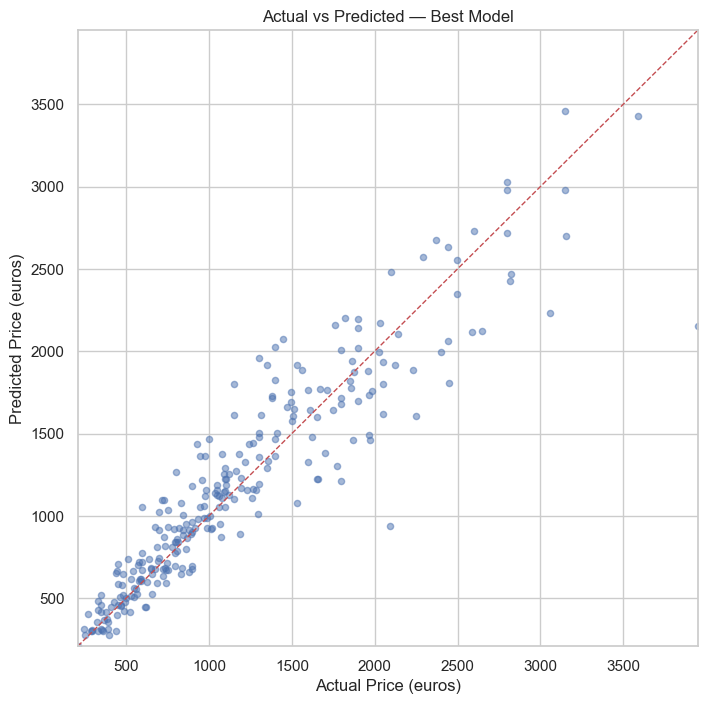

Plot saved to ../reports/figures/actual_vs_predicted_best_model.png


In [13]:
# Step 10 - Choose best model and visualize
best_model = rf if r2_rf >= r2_lr else lin_reg
best_pred = y_pred_rf if best_model is rf else y_pred_lr

plt.figure(figsize=(8,8))
plt.scatter(y_test, best_pred, alpha=0.5, s=20)
lims = [min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=1)  # identity line
plt.xlabel("Actual Price (euros)")
plt.ylabel("Predicted Price (euros)")
plt.title("Actual vs Predicted — Best Model")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.savefig("../reports/figures/actual_vs_predicted_best_model.png", dpi=150)
plt.show()
print("Plot saved to ../reports/figures/actual_vs_predicted_best_model.png")

### Initial Model Training Results

We compared two models: Linear Regression and Random Forest.

- **Linear Regression** achieved an R² of 0.812, RMSE of €304.02, and MAE of €216.53.
- **Random Forest** achieved an R² of 0.858, RMSE of €264.62, and MAE of €176.32.

**Conclusion:** Random Forest performs better overall, explaining more of the variance in laptop prices and reducing prediction error by around €40 on average compared to Linear Regression. We selected Random Forest as the final model and saved it for deployment.


### Step 11 — Save the best model for deployment
- Simply save the model file to `../models` for use in Streamlit or inference.

In [15]:
best_model_path = "../models/laptop_price_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Saved best model to {best_model_path}")
# If you trained linear regression and plan to use the scaler, scaler already saved earlier.

Saved best model to ../models/laptop_price_model.pkl


### Step 12 — Next steps (notes)
- If Random Forest is best, consider GridSearchCV / RandomizedSearchCV to tune hyperparameters.
- If deployment is required, create a small API or Streamlit app that loads `../models/laptop_price_model.pkl` and `../models/scaler.pkl`.
- Save feature list and preprocessing steps (so you apply exactly the same transforms at inference).

In [16]:
# Step 12 - Save feature list
feature_list_path = "../models/feature_names.pkl"
joblib.dump(X_train_encoded.columns.tolist(), feature_list_path)
print(f"Saved feature names to {feature_list_path}")


Saved feature names to ../models/feature_names.pkl
